<a href="https://colab.research.google.com/github/CoGian/NLP-with-Disaster-Tweets/blob/master/EDA_and_Text_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import wordcloud
from wordcloud import WordCloud
# import NLTK mainly for stopwords
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import  word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from PIL import Image
!pip install emoji
import emoji
from collections import Counter
from itertools import chain
import pickle
import operator
import string
!pip install edm
from edm import report
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=623c99981b2afb266076a535e5a1bb4d6b86199fcc67523c47d779bce8411a86
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
  Created wheel for edm: filename=edm-0.0.4-cp36-none-any.whl size=10639 sha256=49263178681df80b0076ae16c92df7989d8ba0295c97f2965b096c1ca293b8ca
  Stored in directory: /root/.cache/pip/wheels/f5/9b/f6/778ef88e921a1c1ef7b9d04d1af501a7014d89e941c3301c56
Successfully built edm


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/train.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/test.csv'
GLOVE_EMBEDDING_PATH = '/content/drive/My Drive/Glove/glove.840B.300d.pkl'
CRAWL_EMBEDDING_PATH = "/content/drive/My Drive/Crawl/crawl-300d-2M.pkl"

In [0]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df =  pd.read_csv(TEST_DATASET_PATH)

Define column names

In [0]:
TARGET_COLUMN = 'target'
LOCATION_COLUMN = 'location'
KEYWORD_COLUMN = 'keyword'
METADADATA_COLUMNS = [LOCATION_COLUMN] + [KEYWORD_COLUMN]
TEXT = 'text'

# Exploratory Data Analysis

## Understanding the Data scheme

Print the first 5 samples

In [9]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
num_of_samples = len(train_df)
print('Train size: {:d}'.format(num_of_samples))

Train size: 7613


In [12]:
# check for amount of missing(null) values in every column αnd print the precentage of them. 
null_columns=train_df.columns[train_df.isnull().any()]
print((train_df[null_columns].isnull().sum() / num_of_samples )* 100)

keyword      0.801261
location    33.272035
dtype: float64


Check the frequency of lengths of training sentences

In [13]:
# tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
tokenizer.fit_on_texts(list(train_df[TEXT].astype(str)))
x_train = tokenizer.texts_to_sequences(list(train_df[TEXT].astype(str)))

# count lengths 
training_sentence_lengths = [len(tokens) for tokens in x_train]
print("Max sentence length is %s" % max(training_sentence_lengths))
targets_n_lens = pd.DataFrame(data=train_df[TARGET_COLUMN],columns=[TARGET_COLUMN])
targets_n_lens['lens'] = training_sentence_lengths

Max sentence length is 33


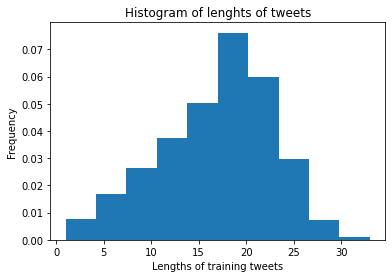

In [14]:
#plot hist 
plt.hist(training_sentence_lengths, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of tweets")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training tweets')
plt.show()

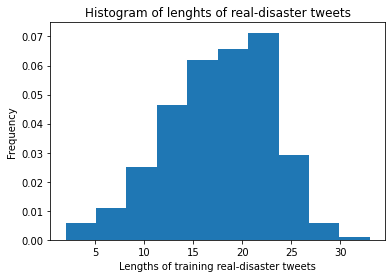

In [16]:
plt.hist(targets_n_lens[targets_n_lens[TARGET_COLUMN] >= .5]['lens'].values, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of real-disaster tweets")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training real-disaster tweets');
plt.show()

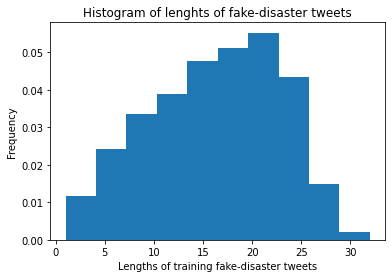

In [17]:
plt.hist(targets_n_lens[targets_n_lens[TARGET_COLUMN] < .5]['lens'].values, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of fake-disaster tweets")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training fake-disaster tweets');
plt.show()

## Understanding the tweets with metadata

In [19]:
num_of_non_toxic_samples = int(train_df[train_df.target < 0.5][TARGET_COLUMN].count())
num_of_toxic_samples = num_of_samples - num_of_non_toxic_samples

print('Nummer of tweets: ',num_of_samples)
print('Nummer of fake-disaster tweets: {:d} ,percentage: {:.2f}%'.format(num_of_non_toxic_samples , (num_of_non_toxic_samples/num_of_samples)*100)) 
print('Nummer of real-disaster tweets: {:d} ,percentage: {:.2f}%'.format(num_of_toxic_samples , (num_of_toxic_samples/num_of_samples)*100)) 

Nummer of tweets:  7613
Nummer of fake-disaster tweets: 4342 ,percentage: 57.03%
Nummer of real-disaster tweets: 3271 ,percentage: 42.97%


Let's drop the samples without metadata and calculate the previous stats

In [22]:
!git

usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone      Clone a repository into a new directory
   init       Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add        Add file contents to the index
   mv         Move or rename a file, a directory, or a symlink
   reset      Reset current HEAD to the specified state
   rm         Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect     Use binary search to find the commit that introduced a bug
   grep       Prin

In [23]:
!ls

drive  sample_data
